In [1]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, greatest
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator 
import seaborn as sns
import matplotlib.pyplot as plt 
import itertools
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("PopulationClustering").getOrCreate()

In [3]:
df = spark.read.option("header", "false").csv('data.csv')
header = df.take(3)

df = df.filter(df['_c0'] != header[0][0])

df.show(5)

+--------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|           _c0|  _c1|  _c2|  _c3|  _c4|  _c5|  _c6|  _c7|  _c8|  _c9| _c10| _c11| _c12| _c13| _c14| _c15| _c16| _c17| _c18|
+--------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|          Aceh|24.68|24.91|24.84|28.95|29.61| 29.4|24.29|21.81|22.65|29.78|26.62|27.66| 23.9|31.03| 28.6|30.42|36.83|34.66|
|Sumatera Utara|23.21| 26.4|24.64|26.54|28.81|27.59|18.08|20.15|18.99|20.87|23.18|21.92|26.24|28.96|27.42| 30.6|34.26|32.17|
|Sumatera Barat|30.46|27.02|28.65|36.32|31.08|33.52|25.04|20.39| 22.7|28.92|23.85|26.31| 15.2|36.02|25.92|19.38| 41.7|30.69|
|          Riau| 25.3|22.42| 23.6|28.32|24.11|25.78|31.57| 15.8|22.19|31.38|18.19| 23.4|   22|28.68|26.05| 24.6|30.92|28.33|
|         Jambi|19.75|20.78|20.44|21.88|23.35|22.87|12.44|17.35|15.73|14.46|19.66|17.96|15.66|29.25|24.81|17.63|32.34| 27.4|


In [4]:
years = ["2020", "2021", "2022"]
genders = ["pria", "wanita"]
locations = ["perkotaan", "perdesaan", "perkotaan+perdesaan"]

for index, (year, gender, location) in enumerate(itertools.product(years, genders, locations), start=1):
    old_col = f"_c{index}"
    new_col = f"{year}-{gender}-{location}"
    df = df.withColumnRenamed(old_col, new_col)
    
df = df.withColumnRenamed('_c0', 'provinsi')
df = df.filter(col("provinsi") != "INDONESIA")
df.show(100)

+--------------------+-------------------+-------------------+-----------------------------+---------------------+---------------------+-------------------------------+-------------------+-------------------+-----------------------------+---------------------+---------------------+-------------------------------+-------------------+-------------------+-----------------------------+---------------------+---------------------+-------------------------------+
|            provinsi|2020-pria-perkotaan|2020-pria-perdesaan|2020-pria-perkotaan+perdesaan|2020-wanita-perkotaan|2020-wanita-perdesaan|2020-wanita-perkotaan+perdesaan|2021-pria-perkotaan|2021-pria-perdesaan|2021-pria-perkotaan+perdesaan|2021-wanita-perkotaan|2021-wanita-perdesaan|2021-wanita-perkotaan+perdesaan|2022-pria-perkotaan|2022-pria-perdesaan|2022-pria-perkotaan+perdesaan|2022-wanita-perkotaan|2022-wanita-perdesaan|2022-wanita-perkotaan+perdesaan|
+--------------------+-------------------+-------------------+----------------

In [5]:
df.printSchema()

root
 |-- provinsi: string (nullable = true)
 |-- 2020-pria-perkotaan: string (nullable = true)
 |-- 2020-pria-perdesaan: string (nullable = true)
 |-- 2020-pria-perkotaan+perdesaan: string (nullable = true)
 |-- 2020-wanita-perkotaan: string (nullable = true)
 |-- 2020-wanita-perdesaan: string (nullable = true)
 |-- 2020-wanita-perkotaan+perdesaan: string (nullable = true)
 |-- 2021-pria-perkotaan: string (nullable = true)
 |-- 2021-pria-perdesaan: string (nullable = true)
 |-- 2021-pria-perkotaan+perdesaan: string (nullable = true)
 |-- 2021-wanita-perkotaan: string (nullable = true)
 |-- 2021-wanita-perdesaan: string (nullable = true)
 |-- 2021-wanita-perkotaan+perdesaan: string (nullable = true)
 |-- 2022-pria-perkotaan: string (nullable = true)
 |-- 2022-pria-perdesaan: string (nullable = true)
 |-- 2022-pria-perkotaan+perdesaan: string (nullable = true)
 |-- 2022-wanita-perkotaan: string (nullable = true)
 |-- 2022-wanita-perdesaan: string (nullable = true)
 |-- 2022-wanita-perko

In [6]:
#jalanin dua kali biar kagak error

df = df.replace(0, None)

selected_columns = df.columns[1:]

for col_name in selected_columns:
    df = df.withColumn(col_name, df[col_name].cast("double"))
    
# Calculate mean values
mean_values = df.agg(*(mean(column).alias(column) for column in df.columns)).collect()[0].asDict()

# Replace missing values with mean
for column in df.columns:
    df = df.withColumn(column, when(df[column].isNull(), mean_values[column]).otherwise(df[column]))

In [7]:
df_clustering = df.select(selected_columns + ["provinsi"])
vec_assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")
final_data = vec_assembler.transform(df_clustering)
final_data.select('provinsi','features').show(5)

+--------------+--------------------+
|      provinsi|            features|
+--------------+--------------------+
|          Aceh|[24.68,24.91,24.8...|
|Sumatera Utara|[23.21,26.4,24.64...|
|Sumatera Barat|[30.46,27.02,28.6...|
|          Riau|[25.3,22.42,23.6,...|
|         Jambi|[19.75,20.78,20.4...|
+--------------+--------------------+
only showing top 5 rows



In [8]:
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(final_data) 
  
# Normalize each feature to have unit standard deviation. 
final_data = scalerModel.transform(final_data) 
  
final_data.select('provinsi', 'features' ,'scaledFeatures').show(30)

+--------------------+--------------------+--------------------+
|            provinsi|            features|      scaledFeatures|
+--------------------+--------------------+--------------------+
|                Aceh|[24.68,24.91,24.8...|[4.05565383671143...|
|      Sumatera Utara|[23.21,26.4,24.64...|[3.81408936588624...|
|      Sumatera Barat|[30.46,27.02,28.6...|[5.00547876281322...|
|                Riau|[25.3,22.42,23.6,...|[4.15753817134519...|
|               Jambi|[19.75,20.78,20.4...|[3.24550904680109...|
|    Sumatera Selatan|[29.01,27.28,27.9...|[4.76720088342782...|
|            Bengkulu|[28.76,28.94,28.8...|[4.72611849043034...|
|             Lampung|[28.82,30.07,29.6...|[4.73597826474974...|
|Kepulauan Bangka ...|[31.13,26.27,28.9...|[5.11557957604647...|
|      Kepulauan Riau|[16.37,18.85,16.6...|[2.69007509347513...|
|         DKI Jakarta|[31.85,0.0,31.85,...|[5.23389686787922...|
|          Jawa Barat|[30.04,31.96,30.4...|[4.93646034257745...|
|         Jawa Tengah|[33

In [9]:
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures',
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 
  
for i in range(2,10): 
    kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
    model=kmeans.fit(final_data) 
    predictions=model.transform(final_data) 
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.5989702010532477
Silhouette Score for k = 3 is 0.4832006971155232
Silhouette Score for k = 4 is 0.418674393370089
Silhouette Score for k = 5 is 0.4098499211082234
Silhouette Score for k = 6 is 0.3389358857614796
Silhouette Score for k = 7 is 0.4369190677964638
Silhouette Score for k = 8 is 0.41961788988484355
Silhouette Score for k = 9 is 0.2701726227491834


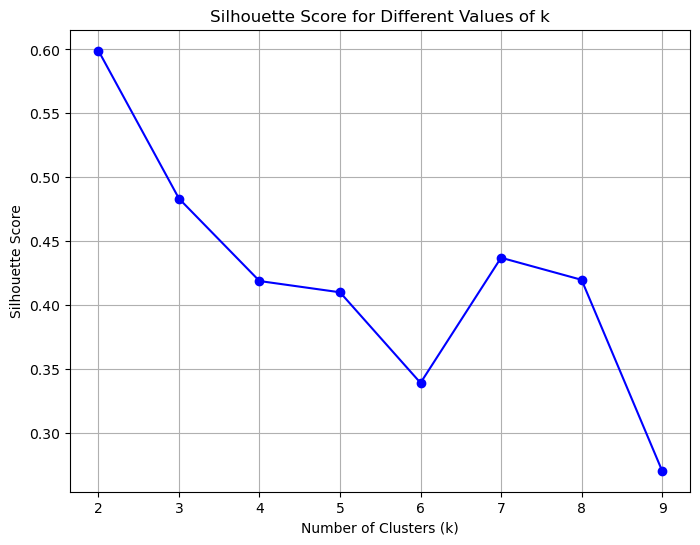

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_score, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [11]:
# Trains a k-means model. 
kmeans = KMeans(featuresCol='scaledFeatures',k=8) 
model = kmeans.fit(final_data) 
predictions = model.transform(final_data)

# Printing cluster centers 
centers = model.clusterCenters() 
print("Cluster Centers: ") 
for center in centers: 
	print(center)


Cluster Centers: 
[4.83375436 4.04392754 4.93627975 5.35133976 4.07405095 5.21901133
 3.78182784 3.10265565 4.48598349 4.18050936 3.2321504  4.60823088
 2.2196594  3.7652065  3.47457379 2.49505114 3.83582288 3.65328885]
[5.23389687 0.         5.35401022 5.5308007  0.         5.49005899
 3.46036223 0.         4.51627012 3.69640651 0.         4.41891978
 1.92204411 0.         2.13797489 2.10418777 0.         2.27884199]
[2.64611693 2.18843594 2.69969871 2.93712591 2.16441294 2.83947387
 1.85098666 2.04209641 2.47192299 2.23159604 2.12621953 2.64578878
 1.75553688 1.8291122  2.05995193 1.97439955 1.89019452 2.14996731]
[5.23204816 4.26769634 5.39477466 5.38614899 4.29463087 5.49236251
 4.29542204 3.82349565 5.11287207 4.69447795 3.85069619 5.19609169
 3.81065567 3.81025159 4.49251818 4.10271654 3.80117673 4.60913647]
[3.81361985 3.13918951 3.93403881 4.05930935 3.01838702 3.95657199
 3.70294835 2.65358565 3.93420701 3.89227022 2.57157828 3.87423519
 2.63770681 2.82834905 3.2521719  2.7124

In [12]:
predictions.select('provinsi', 'features', 'prediction').show(30)

+--------------------+--------------------+----------+
|            provinsi|            features|prediction|
+--------------------+--------------------+----------+
|                Aceh|[24.68,24.91,24.8...|         7|
|      Sumatera Utara|[23.21,26.4,24.64...|         6|
|      Sumatera Barat|[30.46,27.02,28.6...|         0|
|                Riau|[25.3,22.42,23.6,...|         4|
|               Jambi|[19.75,20.78,20.4...|         6|
|    Sumatera Selatan|[29.01,27.28,27.9...|         7|
|            Bengkulu|[28.76,28.94,28.8...|         7|
|             Lampung|[28.82,30.07,29.6...|         3|
|Kepulauan Bangka ...|[31.13,26.27,28.9...|         7|
|      Kepulauan Riau|[16.37,18.85,16.6...|         2|
|         DKI Jakarta|[31.85,0.0,31.85,...|         1|
|          Jawa Barat|[30.04,31.96,30.4...|         3|
|         Jawa Tengah|[33.94,33.74,33.8...|         3|
|       DI Yogyakarta|[35.6,36.46,35.82...|         3|
|          Jawa Timur|[31.14,31.48,31.2...|         3|
|         

In [13]:
df_result = predictions.withColumn("avg_pria", (F.col("2020-pria-perkotaan+perdesaan") + F.col("2021-pria-perkotaan+perdesaan") + F.col("2022-pria-perkotaan+perdesaan")) / 3).withColumn("avg_wanita",(F.col("2020-wanita-perkotaan+perdesaan") + F.col("2021-wanita-perkotaan+perdesaan") + F.col("2022-wanita-perkotaan+perdesaan")) / 3).select("provinsi","avg_pria", "avg_wanita", "prediction", "2020-pria-perkotaan+perdesaan", "2021-pria-perkotaan+perdesaan", "2022-pria-perkotaan+perdesaan", "2020-wanita-perkotaan+perdesaan", "2021-wanita-perkotaan+perdesaan", "2022-wanita-perkotaan+perdesaan")

avg_growth_by_cluster = (
    df_result
    .groupBy("prediction")
    .agg(
        F.mean(predictions["2020-pria-perkotaan+perdesaan"]).alias("avg_pria_2020"),
        F.mean(predictions["2021-pria-perkotaan+perdesaan"]).alias("avg_pria_2021"),
        F.mean(predictions["2022-pria-perkotaan+perdesaan"]).alias("avg_pria_2022"),
        F.mean(predictions["2020-wanita-perkotaan+perdesaan"]).alias("avg_wanita_2020"),
        F.mean(predictions["2021-wanita-perkotaan+perdesaan"]).alias("avg_wanita_2021"),
        F.mean(predictions["2022-wanita-perkotaan+perdesaan"]).alias("avg_wanita_2022"),
    )
)

avg_growth_by_cluster.show()
avg_pria_and_wanita_by_prediction = avg_growth_by_cluster.withColumn(
    "avg_pria",
    (F.col("avg_pria_2020") + F.col("avg_pria_2021") + F.col("avg_pria_2022")) / 3
).withColumn(
    "avg_wanita",
    (F.col("avg_wanita_2020") + F.col("avg_wanita_2021") + F.col("avg_wanita_2022")) / 3
).select('prediction', 'avg_pria', 'avg_wanita')

avg_pria_and_wanita_by_prediction.show()

avg_pria_value = (avg_pria_and_wanita_by_prediction.select("avg_pria").collect()[0][0] + avg_pria_and_wanita_by_prediction.select("avg_pria").collect()[1][0] + avg_pria_and_wanita_by_prediction.select("avg_pria").collect()[2][0])
avg_wanita_value = (avg_pria_and_wanita_by_prediction.select("avg_wanita").collect()[0][0] + avg_pria_and_wanita_by_prediction.select("avg_wanita").collect()[1][0] + avg_pria_and_wanita_by_prediction.select("avg_wanita").collect()[2][0])
gender_tertinggi = "Pria" if avg_pria_value > avg_wanita_value else "Wanita"

print(f"Nilai rata-rata pria: {avg_pria_value / 3}")
print(f"Nilai rata-rata wanita: {avg_wanita_value / 3}")
print(f"Gender dengan Rata-rata Tertinggi: {gender_tertinggi}")

+----------+------------------+-----------------+------------------+------------------+------------------+------------------+
|prediction|     avg_pria_2020|    avg_pria_2021|     avg_pria_2022|   avg_wanita_2020|   avg_wanita_2021|   avg_wanita_2022|
+----------+------------------+-----------------+------------------+------------------+------------------+------------------+
|         1|             31.85|            25.35|             14.66|             35.75|             26.61|             17.55|
|         6|23.126666666666665|18.19333333333333|25.459999999999997|25.963333333333335|20.903333333333332|28.623333333333335|
|         3|           32.0925|         28.69875|30.804999999999996|            35.765|             31.29|          35.49625|
|         5|             41.96|            39.87|             41.98|             45.93|             44.36|             46.21|
|         4| 23.40285714285714|22.08285714285714|22.300000000000004|25.764285714285712|23.330000000000002|24.824285714

In [14]:
# Create a Window specification for ranking by "avg_pria"
window_spec_pria = Window.orderBy(F.col("avg_pria").desc())
rank_pria = df_result.withColumn("rank", F.rank().over(window_spec_pria))

# Create a Window specification for ranking by "avg_wanita"
window_spec_wanita = Window.orderBy(F.col("avg_wanita").desc())
rank_wanita = df_result.withColumn("rank", F.rank().over(window_spec_wanita))

# Select the required columns for each ranking
rank_pria = rank_pria.select("provinsi", "avg_pria", "rank")
rank_wanita = rank_wanita.select("provinsi", "avg_wanita", "rank")

# Show the results
rank_pria.show()
rank_wanita.show()

+--------------------+------------------+----+
|            provinsi|          avg_pria|rank|
+--------------------+------------------+----+
| Nusa Tenggara Barat|             41.27|   1|
|       DI Yogyakarta|             32.77|   2|
|         Jawa Tengah|31.646666666666665|   3|
|           Gorontalo|30.843333333333334|   4|
|  Kalimantan Selatan|             30.66|   5|
| Nusa Tenggara Timur|29.840000000000003|   6|
|          Jawa Barat|29.636666666666667|   7|
|          Jawa Timur|29.623333333333335|   8|
|Kepulauan Bangka ...|29.293333333333333|   9|
|             Lampung|29.236666666666668|  10|
|    Sumatera Selatan|             28.47|  11|
|    Sulawesi Selatan|28.319999999999997|  12|
|    Kalimantan Utara| 27.78333333333333|  13|
|   Sulawesi Tenggara|             27.24|  14|
|            Bengkulu|26.963333333333328|  15|
|              Banten|             26.49|  16|
|      Sulawesi Barat|25.796666666666663|  17|
|      Sumatera Barat|25.756666666666664|  18|
|            

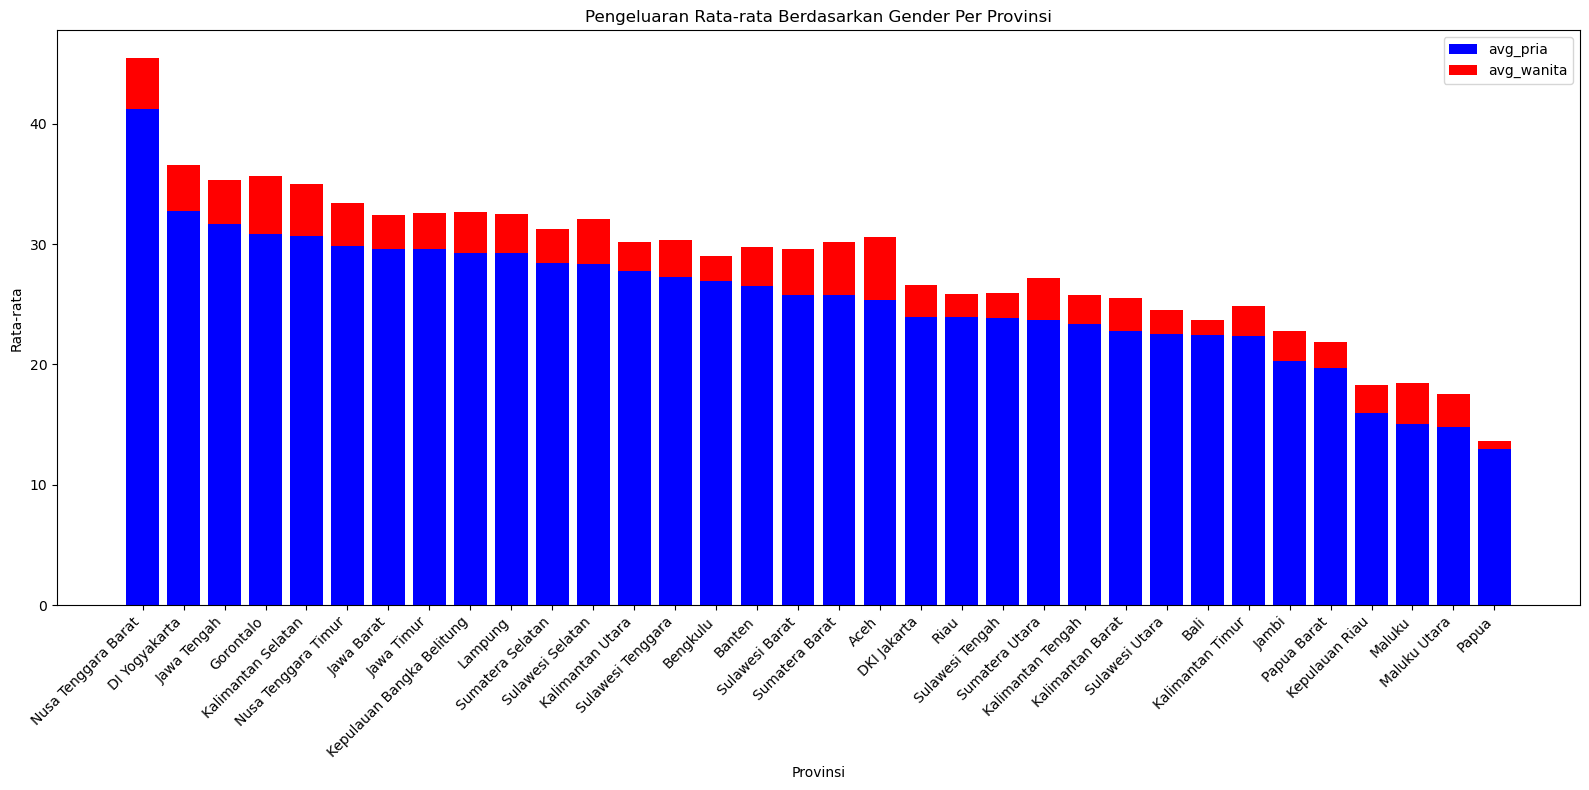

In [15]:
# Ambil data yang diperlukan untuk visualisasi
visualization_data_pria = rank_pria.toPandas()
visualization_data_wanita = rank_wanita.toPandas()

# Gabungkan kedua dataframe berdasarkan kolom "provinsi"
visualization_data = pd.merge(visualization_data_pria, visualization_data_wanita, on="provinsi")

# Set up plot
plt.figure(figsize=(16, 8))

colors = {"avg_pria": "blue", "avg_wanita": "red"}

# Loop untuk setiap kolom yang diinginkan
for idx, col in enumerate(["avg_pria", "avg_wanita"]):
    plt.bar(visualization_data["provinsi"], visualization_data[col], label=col, color=colors[col] ,zorder=2 - idx)  # Menggunakan zorder untuk mengatur kedalaman bar

# Tambahkan label dan judul
plt.xlabel("Provinsi")
plt.ylabel("Rata-rata")
plt.title("Pengeluaran Rata-rata Berdasarkan Gender Per Provinsi")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Tampilkan plot
plt.show()


In [16]:
# Menghitung nilai rata-rata di perdesaan
avg_perdesaan = (
    F.col("2020-pria-perdesaan") + F.col("2021-pria-perdesaan") + F.col("2022-pria-perdesaan") +
    F.col("2020-wanita-perdesaan") + F.col("2021-wanita-perdesaan") + F.col("2022-wanita-perdesaan")
) / 6

# Menghitung nilai rata-rata di perkotaan
avg_perkotaan = (
    F.col("2020-pria-perkotaan") + F.col("2021-pria-perkotaan") + F.col("2022-pria-perkotaan") +
    F.col("2020-wanita-perkotaan") + F.col("2021-wanita-perkotaan") + F.col("2022-wanita-perkotaan")
) / 6

# Seleksi kolom-kolom yang diperlukan
df_result = predictions.select("provinsi", avg_perdesaan.alias("nilai_rata_perdesaan"), avg_perkotaan.alias("nilai_rata_perkotaan"))

df_result.show()

+--------------------+--------------------+--------------------+
|            provinsi|nilai_rata_perdesaan|nilai_rata_perkotaan|
+--------------------+--------------------+--------------------+
|                Aceh|  28.468333333333334|   27.00333333333334|
|      Sumatera Utara|  26.959999999999997|  24.256666666666664|
|      Sumatera Barat|               30.01|  25.886666666666667|
|                Riau|  23.353333333333335|  27.194999999999997|
|               Jambi|   23.78833333333333|               16.97|
|    Sumatera Selatan|  28.051666666666662|              32.875|
|            Bengkulu|  24.888333333333335|  34.281666666666666|
|             Lampung|  31.031666666666666|  30.564999999999998|
|Kepulauan Bangka ...|   28.68166666666667|   32.79833333333333|
|      Kepulauan Riau|               20.24|  16.706666666666667|
|         DKI Jakarta|                 0.0|              25.295|
|          Jawa Barat|               32.56|  30.591666666666665|
|         Jawa Tengah|   

In [17]:
# Fungsi untuk menghitung rata-rata di suatu lokasi (perkotaan atau perdesaan) untuk semua tahun
def calculate_avg(location_prefix):
    return sum([F.col(f"{year}-{location_prefix}") for year in range(2020, 2023)]) / 3

# Menghitung rata-rata di perdesaan
avg_perdesaan = calculate_avg("pria-perdesaan") + calculate_avg("wanita-perdesaan")

# Menghitung rata-rata di perkotaan
avg_perkotaan = calculate_avg("pria-perkotaan") + calculate_avg("wanita-perkotaan")

# Menambahkan kolom untuk menentukan apakah di provinsi itu lebih banyak di perdesaan atau di perkotaan
df_result = predictions.withColumn(
    "dominant_location",
    F.when(avg_perdesaan > avg_perkotaan, "Perdesaan").otherwise("Perkotaan")
).select("provinsi", "dominant_location")

df_result.show()

+--------------------+-----------------+
|            provinsi|dominant_location|
+--------------------+-----------------+
|                Aceh|        Perdesaan|
|      Sumatera Utara|        Perdesaan|
|      Sumatera Barat|        Perdesaan|
|                Riau|        Perkotaan|
|               Jambi|        Perdesaan|
|    Sumatera Selatan|        Perkotaan|
|            Bengkulu|        Perkotaan|
|             Lampung|        Perdesaan|
|Kepulauan Bangka ...|        Perkotaan|
|      Kepulauan Riau|        Perdesaan|
|         DKI Jakarta|        Perkotaan|
|          Jawa Barat|        Perdesaan|
|         Jawa Tengah|        Perkotaan|
|       DI Yogyakarta|        Perdesaan|
|          Jawa Timur|        Perkotaan|
|              Banten|        Perdesaan|
|                Bali|        Perdesaan|
| Nusa Tenggara Barat|        Perdesaan|
| Nusa Tenggara Timur|        Perkotaan|
|    Kalimantan Barat|        Perdesaan|
+--------------------+-----------------+
only showing top

In [18]:
# Menghitung perubahan nilai dari tahun ke tahun di perdesaan dan perkotaan
for year in range(2021, 2023):
    for gender in ["pria", "wanita"]:
        for location in ["perdesaan", "perkotaan"]:
            col_name = f"change_{year}_{gender}_{location}"
            predictions = predictions.withColumn(
                col_name,
                F.col(f"{year}-{gender}-{location}") - F.col(f"2020-{gender}-{location}")
            )

# Menentukan kategori kenaikan atau penurunan untuk setiap tahun dan lokasi
for location in ["perdesaan", "perkotaan"]:
    for year in range(2021, 2023):
        trend_col_name = f"trend_{year}_{location}"
        predictions = predictions.withColumn(
            trend_col_name,
            F.when(F.col(f"change_{year}_pria_{location}") + F.col(f"change_{year}_wanita_{location}") > 0, "Kenaikan").otherwise("Penurunan")
        )

# Menampilkan hasil
result_columns = ["provinsi"] + [f"trend_{year}_{location}" for year in range(2021, 2023) for location in ["perdesaan", "perkotaan"]]
df_result = predictions.select(result_columns)
df_result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|            provinsi|trend_2021_perdesaan|trend_2021_perkotaan|trend_2022_perdesaan|trend_2022_perkotaan|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Aceh|           Penurunan|            Kenaikan|            Kenaikan|            Kenaikan|
|      Sumatera Utara|           Penurunan|           Penurunan|            Kenaikan|            Kenaikan|
|      Sumatera Barat|           Penurunan|           Penurunan|            Kenaikan|           Penurunan|
|                Riau|           Penurunan|            Kenaikan|            Kenaikan|           Penurunan|
|               Jambi|           Penurunan|           Penurunan|            Kenaikan|           Penurunan|
|    Sumatera Selatan|           Penurunan|            Kenaikan|            Kenaikan|            Kenaikan|
|            Bengkulu|           Penu

In [19]:
# Menghitung perubahan nilai dari tahun ke tahun di perdesaan dan perkotaan
for year in range(2021, 2023):
    for gender in ["pria", "wanita"]:
        for location in ["perdesaan", "perkotaan"]:
            col_name = f"change_{year}_{gender}_{location}"
            predictions = predictions.withColumn(
                col_name,
                F.col(f"{year}-{gender}-{location}") - F.col(f"2020-{gender}-{location}")
            )

# Menentukan kategori kenaikan atau penurunan untuk setiap tahun dan lokasi
for year in range(2021, 2023):
    col_name = f"total_change_{year}"
    predictions = predictions.withColumn(
        col_name,
        sum([F.col(f"change_{year}_pria_perdesaan") + F.col(f"change_{year}_wanita_perdesaan") + F.col(f"change_{year}_pria_perkotaan") + F.col(f"change_{year}_wanita_perkotaan")])
    )

    trend_col_name = f"total_trend_{year}"
    predictions = predictions.withColumn(
        trend_col_name,
        F.when(F.col(col_name) > 0, "Kenaikan").otherwise("Penurunan")
    )

# Menampilkan hasil
result_columns = ["provinsi"] + [f"{col_name}" for col_name in ["total_trend_2021", "total_change_2021", "total_trend_2022", "total_change_2022"]]
df_result = predictions.select(result_columns).distinct()

# Menampilkan hasil
df_result.show()


+-------------------+----------------+-------------------+----------------+-------------------+
|           provinsi|total_trend_2021|  total_change_2021|total_trend_2022|  total_change_2022|
+-------------------+----------------+-------------------+----------------+-------------------+
|  Sulawesi Tenggara|       Penurunan| -8.509999999999998|        Kenaikan|  4.920000000000002|
|               Riau|       Penurunan| -3.210000000000001|        Kenaikan|  6.050000000000001|
|   Kalimantan Timur|       Penurunan|-10.699999999999996|        Kenaikan| 25.040000000000003|
|   Kalimantan Barat|       Penurunan|-15.520000000000007|       Penurunan| -6.300000000000001|
|            Lampung|       Penurunan| -1.230000000000004|       Penurunan|-1.3700000000000045|
|        DKI Jakarta|       Penurunan|             -15.64|       Penurunan|             -35.39|
|     Kepulauan Riau|       Penurunan|-18.340000000000003|        Kenaikan|               13.7|
| Kalimantan Selatan|       Penurunan|-1

In [20]:
# Menghitung perubahan nilai dari tahun ke tahun di perdesaan dan perkotaan
for year in range(2021, 2023):
    for gender in ["pria", "wanita"]:
        for location in ["perdesaan", "perkotaan"]:
            col_name = f"change_{year}_{gender}_{location}"
            predictions = predictions.withColumn(
                col_name,
                F.col(f"{year}-{gender}-{location}") - F.col(f"2020-{gender}-{location}")
            )

# Menentukan kategori kenaikan atau penurunan untuk setiap tahun dan lokasi
for year in range(2021, 2023):
    col_name = f"total_change_{year}"
    predictions = predictions.withColumn(
        col_name,
        sum([F.col(f"change_{year}_pria_perdesaan") + F.col(f"change_{year}_wanita_perdesaan") + F.col(f"change_{year}_pria_perkotaan") + F.col(f"change_{year}_wanita_perkotaan")])
    )

    trend_col_name = f"trend_{year}"
    predictions = predictions.withColumn(
        trend_col_name,
        F.when(F.col(col_name) > 0, "Kenaikan").otherwise("Penurunan")
    )

# Menghitung total perubahan dari tahun 2020 hingga 2023
col_name_total = "total_change_2020_2023"
predictions = predictions.withColumn(
    col_name_total,
    sum([F.col(f"total_change_{year}") for year in range(2021, 2023)])
)

# Menentukan kategori kenaikan atau penurunan untuk total tahun 2020-2023
trend_col_name_total = "trend_2020_2023"
predictions = predictions.withColumn(
    trend_col_name_total,
    F.when(F.col(col_name_total) > 0, "Kenaikan").otherwise("Penurunan")
)

# Menampilkan hasil
result_columns = ["provinsi", trend_col_name_total, col_name_total]
df_result = predictions.select(result_columns).distinct()

# Menampilkan hasil
df_result.show()


+--------------------+---------------+----------------------+
|            provinsi|trend_2020_2023|total_change_2020_2023|
+--------------------+---------------+----------------------+
|                Bali|      Penurunan|    -35.43000000000001|
|    Sulawesi Selatan|       Kenaikan|                 15.59|
|      Kepulauan Riau|      Penurunan|    -4.640000000000004|
|              Banten|      Penurunan|    -54.31000000000001|
|          Jawa Timur|      Penurunan|   -20.100000000000012|
|Kepulauan Bangka ...|      Penurunan|   -4.1999999999999815|
| Nusa Tenggara Barat|      Penurunan|    -6.419999999999995|
|     Sulawesi Tengah|      Penurunan|    -9.570000000000004|
|            Bengkulu|      Penurunan|    -8.820000000000011|
|        Maluku Utara|      Penurunan|                 -5.82|
|      Sulawesi Utara|      Penurunan|   -18.209999999999997|
|    Sumatera Selatan|       Kenaikan|     8.769999999999996|
|         Papua Barat|      Penurunan|    -4.079999999999995|
|    Kal